In [14]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import keras

from PIL import Image
from keras.applications import mobilenet_v2
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
# Constants
DATA_SRC = 'garbage_classification/'
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 10

In [17]:
filepaths = []
labels = []

for label in os.listdir(DATA_SRC):
    path = os.path.join(DATA_SRC, label)
    if not os.path.isdir(path) or label.startswith('.'):
        continue
    for file_name in os.listdir(path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(path, file_name))
            labels.append(label)
            
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

In [18]:
print(f"Number of images found: {len(df)}")
print(f"Class distribution: {df['label'].value_counts()}")
df.sample(frac=1)

Number of images found: 15515
Class distribution: label
clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64


,filepath,label
2217,garbage_classification/brown-glass/brown-glass...,brown-glass
6873,garbage_classification/clothes/clothes41.jpg,clothes
6772,garbage_classification/clothes/clothes4008.jpg,clothes
956,garbage_classification/biological/biological10...,biological
12558,garbage_classification/shoes/shoes1441.jpg,shoes
...,...,...
14941,garbage_classification/white-glass/white-glass...,white-glass
7572,garbage_classification/clothes/clothes4729.jpg,clothes
2218,garbage_classification/brown-glass/brown-glass...,brown-glass
10704,garbage_classification/paper/paper551.jpg,paper


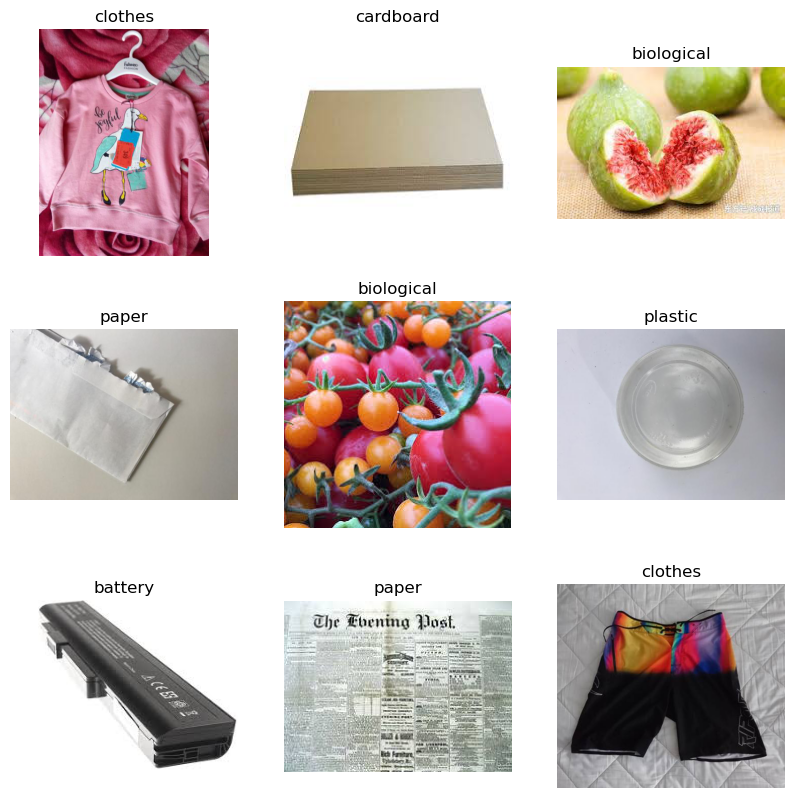

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(df))
    img_path = df.iloc[idx]['filepath']
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(df.iloc[idx]['label'])
    ax.axis('off')

# Model training

In [20]:
mobile_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet',
)
# Freeze the base model
mobile_model.trainable = False

model = Sequential()

model.add(keras.Input(shape=IMG_SHAPE))
model.add(Lambda(lambda x: mobilenet_v2.preprocess_input(x)))
model.add(mobile_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(df['label'].unique()), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['categorical_accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=123)
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=123)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_total = train_df.shape[0]
validate_total = validate_df.shape[0]

In [22]:
# Early stopping implemented here to ensure best efficiency in training
early_stop = EarlyStopping(patience=2, verbose=1, monitor='val_categorical_accuracy',
                           mode='max', min_delta=0.001, restore_best_weights=True)

callbacks = [early_stop]

In [23]:

train_data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

train_generator = train_data_gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='categorical',
)

Found 12412 validated image filenames belonging to 12 classes.


In [24]:
validation_data_gen = ImageDataGenerator(
)
validation_generator = validation_data_gen.flow_from_dataframe(
    validate_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 2172 validated image filenames belonging to 12 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//BATCH_SIZE,
    callbacks=callbacks
)
model.save_weights("model.h5")

/home/yousuf/miniconda3/envs/garbageclassifier/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()